# Preprocessing Digital Image Data

## Data Selection

### 1. Loading and Resizing (Tải và Thay đổi kích thước)
#### Rationale (Lý do chọn kích thước 224x224):
* **Tính tương thích:** 224x224 là kích thước đầu vào tiêu chuẩn của nhiều kiến trúc Deep Learning hiện đại (như ResNet, VGG, MobileNet). Việc chuẩn hóa về kích thước này giúp tận dụng được sức mạnh của kỹ thuật Transfer Learning sau này.
* **Độ chi tiết:** Đối với dữ liệu lá cây, kích thước này đủ để bảo toàn các đặc trưng quan trọng như đốm bệnh nhỏ, hình thái gân lá và ranh giới vùng bị tổn thương.

#### Trade-offs:
* **Kích thước lớn hơn (ví dụ 512x512):** Tăng độ sắc nét nhưng làm tăng gấp 4 lần chi phí tính toán và bộ nhớ (Memory footprint), dễ gây lỗi Out-of-Memory (OOM) khi huấn luyện theo Batch.
* **Kích thước nhỏ hơn (ví dụ 64x64):** Tốc độ xử lý cực nhanh nhưng làm mất đi các chi tiết kết cấu (Texture) nhỏ - vốn là dấu hiệu sống còn để phân biệt các loại bệnh có biểu hiện tương đồng.

#### Phương pháp đánh giá:
Để đánh giá chất lượng của quá trình Resize, chúng tôi thực hiện lấy 5 mẫu ngẫu nhiên từ 5 lớp khác nhau. Ảnh sau khi resize xuống 224x224 sẽ được phóng ngược (Upscale) về kích thước gốc để đo đạc:
1. **PSNR (Peak Signal-to-Noise Ratio):** Đo độ lệch giá trị pixel.
2. **SSIM (Structural Similarity Index):** Đo độ bảo toàn cấu trúc và sắc tố lá cây.

In [ ]:
# Imports & Config
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from concurrent.futures import ThreadPoolExecutor, as_completed
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mutual_info_score
ROOT_DIR = r"../data/images/New Plant Diseases Dataset(Augmented)/train"
AUGMENTED_DIR = r"../data/images/New Plant Diseases Dataset(Augmented)/train"
OUTPUT_ROOT = r"../data/images/subset_resized_224"
TARGET_SIZE = (224, 224)

In [ ]:
# THIẾT LẬP DATASET HÌNH ẢNH
class ImageDataset:
    def __init__(self, root_dir, target_size=(224, 224), use_augmentation=False, normalize=True, subset_ratio=1.0, seed=42):
        """
        Khởi tạo dataset bằng cách quét thư mục và ánh xạ các lớp (classes).
        """
        self.root_dir = root_dir
        self.target_size = target_size
        self.use_augmentation = use_augmentation
        self.normalize = normalize
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        supported_ext = ('.jpg', '.jpeg') 


        # Quét các thư mục con (mỗi thư mục đại diện cho một lớp)
        classes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])

        if not classes:
            raise ValueError("Lỗi: Không tìm thấy thư mục con của lớp nào")

        # Tạo ánh xạ giữa tên lớp và chỉ số nguyên
        for idx, cls in enumerate(classes):
            self.class_to_idx[cls] = idx
            self.idx_to_class[idx] = cls

            cls_dir = os.path.join(root_dir, cls)

            # Thu thập tất cả đường dẫn ảnh hợp lệ và nhãn tương ứng
            for f in os.listdir(cls_dir):
                if f.lower().endswith(supported_ext):
                    self.image_paths.append(os.path.join(cls_dir, f))
                    self.labels.append(idx)

        # Xử lý giảm bớt dữ liệu nếu subset_ratio nhỏ hơn 1.0 (hữu ích cho việc tạo nguyên mẫu nhanh)
        if subset_ratio < 1.0:
            random.seed(seed)
            total = len(self.image_paths)
            subset_size = int(total * subset_ratio)

            indices = list(range(total))
            random.shuffle(indices)
            selected = indices[:subset_size]

            # Gán lại đường dẫn và nhãn dựa trên các chỉ số đã chọn
            self.image_paths = [self.image_paths[i] for i in selected]
            self.labels = [self.labels[i] for i in selected]

            print(f" Sử dụng tập con: {subset_size}/{total} ảnh ({subset_ratio*100:.0f}%)")

        print(f" Dataset đã tải: {len(self.image_paths)} ảnh, {len(classes)} lớp")

    def augment(self, image):
        """
        Áp dụng các phép biến đổi ngẫu nhiên cho ảnh để cải thiện khả năng tổng quát hóa của mô hình.
        """
        # Lật ngang ngẫu nhiên (50%)
        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        # Xoay ngẫu nhiên từ -15 đến 15 độ (50% cơ hội)
        if random.random() < 0.5:
            image = image.rotate(random.uniform(-15, 15)) 

        # Điều chỉnh ngẫu nhiên độ sáng, độ tương phản và cân bằng màu sắc (50% cơ hội)
        if random.random() < 0.5:
            image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
            image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
            image = ImageEnhance.Color(image).enhance(random.uniform(0.8, 1.2))

        return image

    def load_image(self, idx):
        """
        Quy trình cốt lõi cho một ảnh đơn lẻ: Đọc -> Thay đổi kích thước -> Tăng cường -> Chuẩn hóa -> Chuyển vị.
        """
        try:
            img_path = self.image_paths[idx]

            # 1. Đọc ảnh bằng OpenCV, chuyển từ BGR sang RGB và thay đổi kích thước
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.target_size)

            # Chuyển sang ảnh PIL để dễ dàng thực hiện tăng cường dữ liệu
            image = Image.fromarray(image)

            if self.use_augmentation:
                image = self.augment(image)

            # 2. Chuyển sang mảng Numpy và tỷ lệ hóa giá trị pixel về khoảng [0, 1]
            image = np.asarray(image, dtype=np.float32) / 255.0

            # 3. Áp dụng chuẩn hóa ImageNet tiêu chuẩn
            if self.normalize:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = (image - mean) / std

            # 4. Chuyển vị từ (H, W, C) sang (C, H, W) để khớp với các framework học sâu (như PyTorch)
            image = np.transpose(image, (2, 0, 1))
            return image, self.labels[idx]

        except Exception as e:
            # Nếu tải ảnh thất bại, trả về một ảnh đen trống để tránh gây lỗi chương trình
            print(f"Lỗi khi tải ảnh: {e}")
            blank = np.zeros((3, *self.target_size), dtype=np.float32)
            return blank, self.labels[idx]
        
# THIẾT LẬP DATA LOADER
class DataLoader:
    def __init__(self, dataset, batch_size=32, shuffle=True):
        """
        Khởi tạo data loader để xử lý việc chia batch và xáo trộn dữ liệu.
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(dataset.image_paths))

    def __iter__(self):
        """
        Tạo một trình lặp (iterator) để cung cấp các batch dữ liệu.
        """
        # Xáo trộn các chỉ số khi bắt đầu mỗi epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

        # Lặp qua các chỉ số để tạo các mini-batch
        for start in range(0, len(self.indices), self.batch_size):
            batch_idx = self.indices[start:start + self.batch_size]

            images, labels = [], []
            # Lấy ảnh đã xử lý và nhãn cho mỗi chỉ số trong batch
            for idx in batch_idx:
                img, lbl = self.dataset.load_image(idx)
                images.append(img)
                labels.append(lbl)

            # Xếp chồng các ảnh đơn lẻ thành một mảng 4D duy nhất (Batch_size, Channels, Height, Width)
            yield np.stack(images), np.array(labels)

    def __len__(self):
        """
        Trả về số lượng batch trong mỗi epoch.
        """
        return len(self.indices) // self.batch_size

In [3]:
# PIPELINE BUILDER SETUP
def BuildImagePipeline(
    root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    use_augmentation=False,
    normalize=True,
    subset_ratio=1.0,
    seed=42,
):
    dataset = ImageDataset(
        root_dir=root_dir,
        target_size=target_size,
        use_augmentation=use_augmentation,
        normalize=normalize,
        subset_ratio=subset_ratio,
        seed=seed
    )

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle
    )

    print(f" Total images: {len(dataset.image_paths)}")
    print(f" Classes: {len(dataset.class_to_idx)}")
    print(f" Batches per epoch: {len(loader)}")

    return dataset, loader

dataset, loader = BuildImagePipeline(
    root_dir=ROOT_DIR,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    normalize=True
)


 Dataset loaded: 70295 images, 38 classes
 Total images: 70295
 Classes: 38
 Batches per epoch: 2196


In [4]:
# RESIZE & SAVE PIPELINE    
NUM_WORKERS = min(16, os.cpu_count() * 2)

os.makedirs(OUTPUT_ROOT, exist_ok=True)

def ResizeAndSave(img_path, label):
    try:
        class_name = dataset.idx_to_class[label]
        out_dir = os.path.join(OUTPUT_ROOT, class_name)
        os.makedirs(out_dir, exist_ok=True)

        out_path = os.path.join(out_dir, os.path.basename(img_path))

        img = cv2.imread(img_path)
        if img is None:
            return False

        img = cv2.resize(img, TARGET_SIZE)
        return cv2.imwrite(out_path, img)
    except Exception:
        return False

tasks = list(zip(dataset.image_paths, dataset.labels))

success = 0
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    futures = [
        executor.submit(ResizeAndSave, p, l)
        for p, l in tasks
    ]

    for f in tqdm(as_completed(futures), total=len(futures)):
        if f.result():
            success += 1

print(f"Loading {success}/{len(tasks)} images")


100%|██████████| 70295/70295 [00:45<00:00, 1530.24it/s]

Loading 70295/70295 images


#### Loader & Resizing statistics

In [ ]:
# LỚP ĐÁNH GIÁ HIỆU SUẤT (PERFORMANCE EVALUATION CLASS)

class ResizingEvaluator:
    def __init__(self, DatasetObj, TargetSize=(224, 224)):
        """
        Khởi tạo bộ đánh giá với đối tượng dataset và kích thước mục tiêu.
        """
        self.DatasetObj = DatasetObj
        self.TargetSize = TargetSize
        self.EvaluationResults = []
        
        # Định nghĩa các phương pháp nội suy dưới dạng thuộc tính của lớp
        self.Methods = {
            "INTER_LINEAR": cv2.INTER_LINEAR,
            "INTER_AREA": cv2.INTER_AREA,
            "INTER_NEAREST": cv2.INTER_NEAREST,
            "INTER_CUBIC": cv2.INTER_CUBIC
        }

    def GroupPathsByLabel(self):
        """
        Nhóm các đường dẫn ảnh theo nhãn lớp để thực hiện lấy mẫu phân tầng (stratified sampling).
        """
        Mapping = {}
        for Path, Label in zip(self.DatasetObj.image_paths, self.DatasetObj.labels):
            if Label not in Mapping:
                Mapping[Label] = []
            Mapping[Label].append(Path)
        return Mapping

    def RunEvaluation(self, NumClasses=5):
        """
        Thực hiện đánh giá hiệu suất thay đổi kích thước trên nhiều phương pháp khác nhau.
        """
        LabelToPaths = self.GroupPathsByLabel()
        AvailableLabels = list(LabelToPaths.keys())
        SelectedLabels = random.sample(AvailableLabels, min(NumClasses, len(AvailableLabels)))
        
        self.EvaluationResults = [] # Đặt lại kết quả

        print(f" Bắt đầu đánh giá trên {NumClasses} lớp ngẫu nhiên")

        for Label in SelectedLabels:
            ClassName = self.DatasetObj.idx_to_class[Label]
            ImgPath = random.choice(LabelToPaths[Label])
            
            # Tải ảnh gốc (I) - RGB 8-bit
            ImgOriginal = cv2.imread(ImgPath)
            if ImgOriginal is None: continue
            
            ImgOriginal = cv2.cvtColor(ImgOriginal, cv2.COLOR_BGR2RGB)
            HOrig, WOrig = ImgOriginal.shape[:2]

            for MName, MCode in self.Methods.items():
                # ĐO LƯỜNG HIỆU SUẤT HỆ THỐNG
                # Tính toán thời gian chính xác bằng nan giây
                TStart = time.perf_counter_ns()
                ImgDownscaled = cv2.resize(ImgOriginal, self.TargetSize, interpolation=MCode)
                TEnd = time.perf_counter_ns()
                
                # Chuyển đổi nano giây sang mili giây
                ElapsedMS = (TEnd - TStart) / 1_000_000 
                MemoryKB = ImgDownscaled.nbytes / 1024

                # CÁC CHỈ SỐ CHẤT LƯỢNG (PSNR & SSIM)
                # Khôi phục về kích thước gốc để so sánh ma trận (I')
                ImgRestored = cv2.resize(ImgDownscaled, (WOrig, HOrig), interpolation=MCode)

                ValPSNR = psnr(ImgOriginal, ImgRestored, data_range=255)
                ValSSIM = ssim(ImgOriginal, ImgRestored, channel_axis=2, data_range=255)

                self.EvaluationResults.append({
                    "Class_Name": ClassName,
                    "Method": MName,
                    "Original_Dim": f"{WOrig}x{HOrig}",
                    "Target_Dim": f"{self.TargetSize[0]}x{self.TargetSize[1]}",
                    "PSNR_dB": round(ValPSNR, 4),
                    "SSIM": round(ValSSIM, 4),
                    "Time_ms": round(ElapsedMS, 6),
                    "Memory_KB": round(MemoryKB, 2)
                })

    def ExportReport(self, OutputCSV='resizing_performance.csv'):
        """
        Chuyển đổi kết quả sang DataFrame, xuất ra tệp CSV và trả về DataFrame đó.
        """
        if not self.EvaluationResults:
            print(" Không tìm thấy dữ liệu đánh giá. Hãy chạy RunEvaluation() trước.")
            return None
            
        Df = pd.DataFrame(self.EvaluationResults)
        Df.to_csv(OutputCSV, index=False, encoding='utf-8')
        print(f" Kết quả đã được lưu tại: {OutputCSV}")
        return Df
    

# KÍCH HOẠT (ACTIVATION)

# Khởi tạo đối tượng Evaluator
# Truyền vào đối tượng 'dataset' (thực thể của ImageDataset) đã được tạo ở các ô trước
# target_size=(224, 224) là kích thước đầu vào tiêu chuẩn cho hầu hết các kiến trúc CNN
ResizingEvaluatorObj = ResizingEvaluator(
    DatasetObj=dataset, 
    TargetSize=(224, 224)
)

# Chạy quy trình đánh giá hiệu suất
# NumClasses=5 đảm bảo chúng ta có được một mẫu đại diện qua các danh mục khác nhau
# Bước này đo lường Thời gian, Bộ nhớ, PSNR và SSIM cho mỗi phương pháp nội suy
ResizingEvaluatorObj.RunEvaluation(NumClasses=5)

# Xuất kết quả ra tệp CSV và lấy lại DataFrame
# Báo cáo sẽ được lưu dưới tên 'resizing_performance.csv' để phục vụ lưu trữ tài liệu sau này
df_resizing_stats = ResizingEvaluatorObj.ExportReport(OutputCSV='resizing_performance.csv')

# Hiển thị bảng thống kê chi tiết
# Ta sắp xếp theo PSNR_dB giảm dần để xác định phương pháp có chất lượng cao nhất
if df_resizing_stats is not None:
    print("\n--- TOP 10 KẾT QUẢ HIỆU SUẤT THAY ĐỔI KÍCH THƯỚC (Sắp xếp theo chất lượng) ---")
    display(df_resizing_stats.sort_values(by="PSNR_dB", ascending=False).head(10))

    # Tổng hợp các chỉ số hiệu suất theo Phương pháp nội suy
    # Việc này giúp lựa chọn sự cân bằng tối ưu giữa tốc độ (Thời gian) và chất lượng (PSNR/SSIM)
    print("\n--- HIỆU SUẤT TRUNG BÌNH THEO PHƯƠNG PHÁP NỘI SUY ---")
    summary_by_method = df_resizing_stats.groupby("Method")[["PSNR_dB", "SSIM", "Time_ms"]].mean()
    display(summary_by_method)

 Starting evaluation on 5 random classes
 Results saved at: resizing_performance.csv

--- TOP 10 RESIZING PERFORMANCE RESULTS (Sorted by Quality) ---


,Class_Name,Method,Original_Dim,Target_Dim,PSNR_dB,SSIM,Time_ms,Memory_KB
15,Corn_(maize)___Northern_Leaf_Blight,INTER_CUBIC,256x256,224x224,33.1519,0.9462,0.2311,147.0
19,Grape___healthy,INTER_CUBIC,256x256,224x224,32.6004,0.9297,0.2384,147.0
13,Corn_(maize)___Northern_Leaf_Blight,INTER_AREA,256x256,224x224,30.5366,0.8852,0.4998,147.0
12,Corn_(maize)___Northern_Leaf_Blight,INTER_LINEAR,256x256,224x224,30.4493,0.8819,0.1397,147.0
17,Grape___healthy,INTER_AREA,256x256,224x224,30.0528,0.8516,0.4455,147.0
16,Grape___healthy,INTER_LINEAR,256x256,224x224,29.9859,0.8475,0.1280,147.0
7,Blueberry___healthy,INTER_CUBIC,256x256,224x224,28.4659,0.9002,0.2584,147.0
11,Tomato___Target_Spot,INTER_CUBIC,256x256,224x224,28.0653,0.8871,0.2440,147.0
5,Blueberry___healthy,INTER_AREA,256x256,224x224,26.2373,0.8019,0.5809,147.0
4,Blueberry___healthy,INTER_LINEAR,256x256,224x224,26.1685,0.7970,0.1373,147.0



--- AVERAGE PERFORMANCE PER INTERPOLATION METHOD ---


,PSNR_dB,SSIM,Time_ms
Method,,,
INTER_AREA,26.65546,0.83180,0.75724
INTER_CUBIC,28.97394,0.91586,14.22454
INTER_LINEAR,26.58166,0.82750,0.17518
INTER_NEAREST,19.52898,0.40110,0.12318


### 2. Grayscale Conversion (Chuyển đổi ảnh xám)
Mục tiêu của bước này là định lượng lượng thông tin bị mất khi nén dữ liệu từ 3 kênh màu (RGB) xuống còn 1 kênh duy nhất.

#### Mô hình đánh giá đa chiều:
* **Variance (Phương sai):** Phản ánh độ tương phản (Contrast). So sánh phương sai giữa ảnh màu và ảnh xám giúp nhận biết sự suy giảm chi tiết kết cấu sau khi bỏ màu.
* **Mutual Information (MI - Thông tin tương hỗ):** Đo lượng thông tin chia sẻ giữa ảnh màu và ảnh xám. Giá trị này được chuẩn hóa ($MI_{norm}$) bằng cách chia cho $log_2(256)$.
* **Information Retention (%):** Chỉ số tổng hợp tính theo công thức: $Retention = \frac{SSIM + MI_{norm}}{2} \times 100\%$.

#### Cách tính SSIM đặc thù:
Thay vì so sánh trực tiếp, SSIM được tính giữa ảnh xám với từng kênh (R, G, B) của ảnh màu, sau đó lấy trung bình để đánh giá khả năng bảo toàn đặc trưng sắc tố của lá.

#### Senarios
* **Lợi ích:** Giảm 3 lần dung lượng dữ liệu, tăng tốc độ xử lý cho các bài toán chỉ cần hình dáng lá.
* **Bất lợi:** Đối với bệnh cây trồng, màu sắc (vàng, nâu, đỏ) thường là dấu hiệu nhận diện chính. Nếu chỉ số $Retention$ thấp, việc dùng ảnh xám sẽ gây hại cho độ chính xác của mô hình.

In [ ]:
# GRAYSCALE PROCESSING
# Dataset: 70,295 images 
# 38 classes
# 2,196 batches/epoch

NUM_EPOCHS = 1  # Ta có thể tăng số epoch để kiểm tra tính nhất quán của việc chuyển đổi sang grayscale qua nhiều lần lặp

print(f"Dataset size      : {len(dataset.image_paths)} images")
print(f"Number of classes : {len(dataset.class_to_idx)}")
print(f"Batches / epoch   : {len(loader)}")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    for batch_idx, (images, labels) in enumerate(tqdm(loader, total=len(loader))):
        gray_images = (
            0.299 * images[:, 0] + 0.587 * images[:, 1] + 0.114 * images[:, 2]
        )

        gray_images = gray_images[:, None, :, :]

        if batch_idx == 0:
            print(" RGB batch shape :", images.shape)
            print(" Gray batch shape:", gray_images.shape)

            print(" Gray batch shape:", gray_images.shape)


Dataset size      : 70295 images
Number of classes : 38
Batches / epoch   : 2196

Epoch 1/1


  0%|          | 1/2196 [00:00<06:08,  5.95it/s]

 RGB batch shape : (32, 3, 224, 224)
 Gray batch shape: (32, 1, 224, 224)
 Gray batch shape: (32, 1, 224, 224)


2197it [04:20,  8.44it/s]                          


 Processing 38 disease classes
INFORMATION RETENTION STATISTICAL REPORT


,mean,std,max,min
Retention_%,58.998204,2.237655,63.204638,54.830229


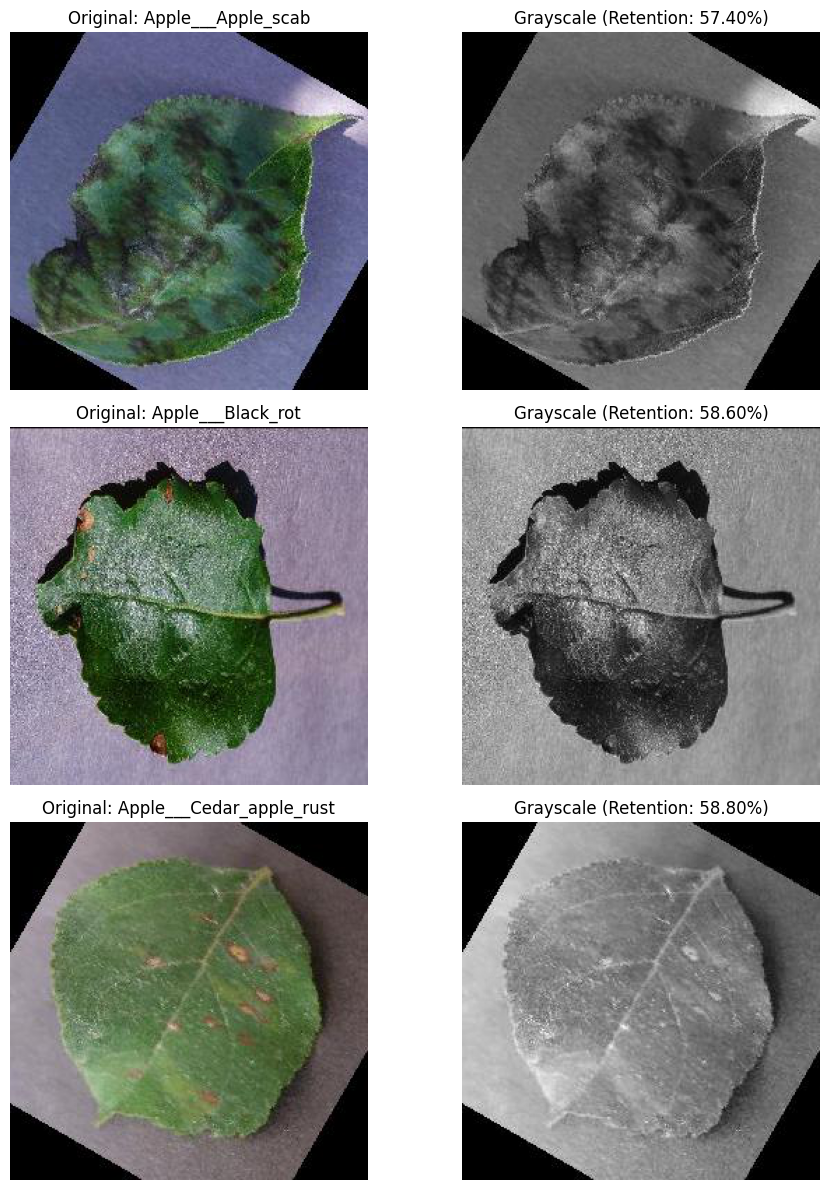

 Detailed report exported to: grayscale_statistical_evaluation.csv


In [ ]:
# ĐÁNH GIÁ ẢNH XÁM (GRAYSCALE EVALUATION)

class GrayscaleEvaluator:
    def __init__(self, DatasetObj):
        """
        Khởi tạo bộ đánh giá với một đối tượng dataset.
        """
        self.DatasetObj = DatasetObj
        self.LabelToPaths = self.GroupPathsByLabel()
        self.Results38Classes = []
        self.VisualSamples = []
        # Trọng số độ sáng tiêu chuẩn (Luminosity): Y = 0.299*R + 0.587*G + 0.114*B
        self.LumiWeights = np.array([0.299, 0.587, 0.114])

    def GroupPathsByLabel(self):
        """
        Tổ chức các đường dẫn ảnh vào các nhóm được phân loại theo nhãn.
        """
        Mapping = {}
        for Path, Label in zip(self.DatasetObj.image_paths, self.DatasetObj.labels):
            if Label not in Mapping:
                Mapping[Label] = []
            Mapping[Label].append(Path)
        return Mapping

    def CalculateGrayscaleMetrics(self, ImgRGB):
        """
        Tính toán các chỉ số để đánh giá mức độ duy trì thông tin khi chuyển từ RGB sang ảnh xám.
        """
        # Kết hợp tuyến tính để chuyển đổi sang ảnh xám (Grayscale)
        ImgGray = (ImgRGB[:,:,0] * self.LumiWeights[0] + 
                   ImgRGB[:,:,1] * self.LumiWeights[1] + 
                   ImgRGB[:,:,2] * self.LumiWeights[2]).astype(np.uint8)
        
        # Tính toán phương sai (Độ trải rộng của độ tương phản)
        VarRGB = np.var(ImgRGB)
        VarGray = np.var(ImgGray)
        
        # Thông tin tương hỗ (Mutual Information - MI)
        # Làm phẳng ảnh thành mảng 1D để kiểm tra sự phụ thuộc thống kê
        RGBFlat = (ImgRGB.mean(axis=2)).ravel() 
        GrayFlat = ImgGray.ravel()
        Hist2D, _, _ = np.histogram2d(RGBFlat, GrayFlat, bins=20)
        MI = mutual_info_score(None, None, contingency=Hist2D)
        MINorm = MI / 8.0  # Chuẩn hóa theo entropy tối đa (8 bits)
        
        # Chỉ số SSIM theo từng kênh màu
        SSIM_R = ssim(ImgRGB[:,:,0], ImgGray, data_range=255)
        SSIM_G = ssim(ImgRGB[:,:,1], ImgGray, data_range=255)
        SSIM_B = ssim(ImgRGB[:,:,2], ImgGray, data_range=255)
        AvgSSIM = (SSIM_R + SSIM_G + SSIM_B) / 3
        
        # Điểm duy trì thông tin tổng hợp cuối cùng
        Retention = ((AvgSSIM + MINorm) / 2) * 100
        
        return {
            "VarRGB": VarRGB, "VarGray": VarGray,
            "MINorm": MINorm, "AvgSSIM": AvgSSIM, "Retention": Retention,
            "ImgGray": ImgGray
        }

    def RunFullEvaluation(self):
        """
        Thực hiện quy trình tính toán chỉ số trên tất cả 38 lớp bệnh lý.
        """
        print(f" Đang xử lý {len(self.LabelToPaths)} lớp bệnh lý")
        self.Results38Classes = []
        self.VisualSamples = []

        for i, (Label, Paths) in enumerate(self.LabelToPaths.items()):
            ImgPath = random.choice(Paths)
            # OpenCV đọc định dạng BGR, chuyển sang RGB để xử lý tiêu chuẩn
            ImgRGB = cv2.cvtColor(cv2.imread(ImgPath), cv2.COLOR_BGR2RGB)
            
            Metrics = self.CalculateGrayscaleMetrics(ImgRGB)
            
            self.Results38Classes.append({
                "Class": self.DatasetObj.idx_to_class[Label],
                "Variance_RGB": Metrics['VarRGB'],
                "Variance_Gray": Metrics['VarGray'],
                "MI_Normalized": Metrics['MINorm'],
                "SSIM_Special": Metrics['AvgSSIM'],
                "Retention_%": Metrics['Retention']
            })
            
            # Lưu trữ 3 mẫu đầu tiên để so sánh trực quan
            if i < 3:
                self.VisualSamples.append({
                    "RGB": ImgRGB, 
                    "Gray": Metrics['ImgGray'], 
                    "Ret": Metrics['Retention'], 
                    "Name": self.DatasetObj.idx_to_class[Label]
                })

    def DisplayResults(self, OutputCSV='grayscale_statistical_evaluation.csv'):
        """
        Tạo báo cáo thống kê, xuất tệp CSV và vẽ biểu đồ các mẫu trực quan.
        """
        if not self.Results38Classes:
            print("Lỗi: Không tìm thấy kết quả. Hãy chạy RunFullEvaluation() trước.")
            return

        DfEval = pd.DataFrame(self.Results38Classes)
        SummaryStats = DfEval["Retention_%"].agg(['mean', 'std', 'max', 'min']).to_frame().T
        
        print("BÁO CÁO THỐNG KÊ MỨC ĐỘ DUY TRÌ THÔNG TIN")
        display(SummaryStats)
        
        # Vẽ biểu đồ các mẫu trực quan
        Fig, Axes = plt.subplots(3, 2, figsize=(10, 12))
        for i, Sample in enumerate(self.VisualSamples):
            Axes[i, 0].imshow(Sample['RGB'])
            Axes[i, 0].set_title(f"Gốc: {Sample['Name']}")
            Axes[i, 0].axis('off')
            
            Axes[i, 1].imshow(Sample['Gray'], cmap='gray')
            Axes[i, 1].set_title(f"Ảnh xám (Duy trì: {Sample['Ret']:.2f}%)")
            Axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()
        
        # Xuất dữ liệu
        DfEval.to_csv(OutputCSV, index=False)
        print(f" Báo cáo chi tiết đã được xuất ra: {OutputCSV}")

# Khởi tạo bộ đánh giá ảnh xám với đối tượng dataset đã tạo trước đó
evaluator = GrayscaleEvaluator(dataset)

# Thực hiện quy trình đánh giá đầy đủ để tính toán các chỉ số cho tất cả các lớp
evaluator.RunFullEvaluation()

# Hiển thị báo cáo thống kê chi tiết và so sánh trực quan
evaluator.DisplayResults()

### 3. Normalization (Chuẩn hóa dữ liệu)
Chúng tôi so sánh ba kỹ thuật chuẩn hóa phổ biến để tìm ra phương pháp tối ưu nhất cho gradient của mô hình.

#### Các phương pháp so sánh:
1. **Min-Max Scaling [0, 1]:** Đưa giá trị pixel về khoảng tuyệt đối, giữ nguyên tỉ lệ sáng-tối gốc.
2. **Min-Max Scaling [-1, 1]:** Thường dùng cho các hàm kích hoạt như Tanh.
3. **Standardization (Z-score):** Đưa giá trị về Mean ≈ 0.0 và Std Dev ≈ 1.0.

#### Phân tích qua Histogram và Thống kê:
* **Mục tiêu:** Kiểm tra xem dải giá trị đã được đưa về đúng tầm mong muốn mà không làm biến dạng hình dạng phân phối (Distribution shape) của dữ liệu.
* **Đánh giá trên tập mẫu lớn:** Thực hiện thống kê trên 380 ảnh (10 ảnh từ mỗi lớp trong 38 lớp) để đảm bảo tính ổn định của dữ liệu, loại bỏ ảnh hưởng của các giá trị ngoại lệ (Outliers).

STATISTICAL SUMMARY OF NORMALIZATION
Source    - Min:   0, Max: 255
Min-Max   - Min: 0.00, Max: 1.00
Standard  - Mean: -0.00, Std: 1.00
Batch Norm- Shape: (32, 1, 224, 224), Mean: 0.00


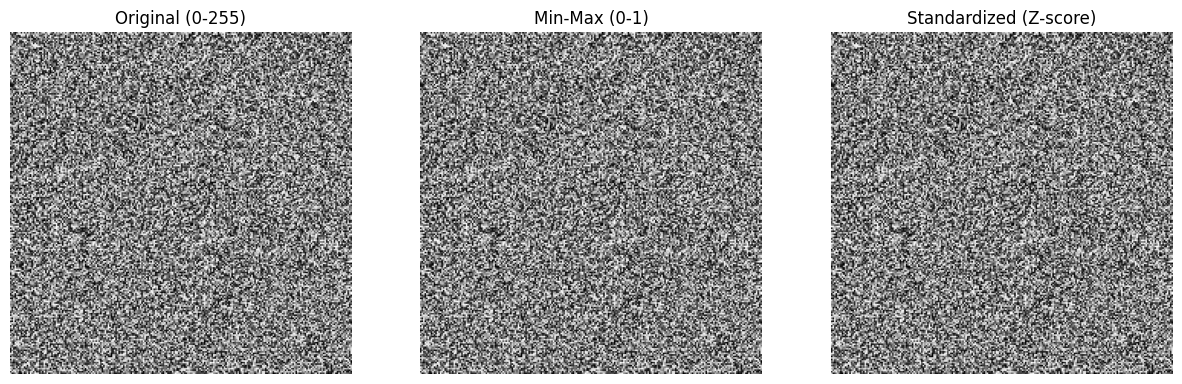

In [ ]:
# CHUẨN HÓA HÌNH ẢNH (IMAGE NORMALIZATION)
class ImageNormalizer:
    def __init__(self, Epsilon=1e-6):
        """
        Khởi tạo bộ chuẩn hóa với một giá trị epsilon an toàn để tránh lỗi chia cho số không.
        """
        self.Epsilon = Epsilon

    def NormalizeBatchwise(self, GrayBatch):
        """
        Thực hiện chuẩn hóa theo batch trên toàn bộ tensor 4D (B, C, H, W).
        
        Phương pháp này coi toàn bộ batch là một phân phối duy nhất để ổn định quá trình huấn luyện 
        bằng cách giảm hiện tượng dịch chuyển hiệp biến nội bộ (internal covariate shift).
        """
        # Tính toán giá trị trung bình (mean) và độ lệch chuẩn (std) toàn cục trên tất cả các chiều (Batch, Channel, Height, Width)
        # keepdims=True là cần thiết để thực hiện broadcasting trong quá trình trừ và chia
        Mean = GrayBatch.mean(axis=(0, 1, 2, 3), keepdims=True)
        Std  = GrayBatch.std(axis=(0, 1, 2, 3), keepdims=True)
        
        # Áp dụng công thức Z-score
        return (GrayBatch - Mean) / (Std + self.Epsilon)

    def NormMinMax(self, Img, TargetRange=(0, 1)):
        """
        Tỷ lệ hóa Min-Max: Thay đổi tỷ lệ dữ liệu về một khoảng cố định, chẳng hạn như [0, 1] hoặc [-1, 1].
        Hữu ích cho các hàm kích hoạt Sigmoid hoặc Tanh trong Mạng thần kinh.
        """
        TMin, TMax = TargetRange
        ImgMin, ImgMax = Img.min(), Img.max()
        
        # Tỷ lệ hóa dữ liệu gốc về khoảng [0, 1]
        ImgNorm = (Img - ImgMin) / (ImgMax - ImgMin + self.Epsilon)
        
        # Ánh xạ về khoảng mục tiêu cuối cùng
        return ImgNorm * (TMax - TMin) + TMin

    def NormStandardization(self, Img):
        """
        Chuẩn hóa cấp độ thực thể (Instance-level Standardization): Thay đổi tỷ lệ một ảnh đơn lẻ về Mean ≈ 0.0 và Std ≈ 1.0.
        Có khả năng chống chịu nhiễu (outliers) tốt hơn so với tỷ lệ hóa Min-Max.
        """
        Mean = np.mean(Img)
        Std = np.std(Img)
        return (Img - Mean) / (Std + self.Epsilon)


# Khởi tạo đối tượng Image Normalizer để thực hiện các kỹ thuật chuẩn hóa khác nhau trên ảnh xám.
normalizer = ImageNormalizer()

# Chuẩn bị một ảnh xám mẫu (224x224) với các giá trị pixel ngẫu nhiên để kiểm tra các phương pháp chuẩn hóa.
ImgGray = np.random.randint(0, 256, (224, 224), dtype=np.uint8)

# Ví dụ dữ liệu batch: 32 ảnh xám kích thước 224x224, mô phỏng một mini-batch để kiểm tra chuẩn hóa.
batch_data = np.random.randint(0, 256, (32, 1, 224, 224), dtype=np.uint8).astype(np.float32)


# CÁC VÍ DỤ CHUẨN HÓA BAN ĐẦU

# Kịch bản 1: Chuẩn hóa một ảnh đơn lẻ bằng tỷ lệ hóa Min-Max, hữu ích cho các hàm kích hoạt như Sigmoid
img_min_max = normalizer.NormMinMax(ImgGray, TargetRange=(0, 1))

# Chuẩn hóa z-score cho một ảnh đơn lẻ, hữu ích cho việc Chuẩn hóa trước khi đưa vào các mô hình như ResNet
img_standard = normalizer.NormStandardization(ImgGray)


# Kịch bản 2: Chuẩn hóa dữ liệu batch trước khi đưa vào mô hình
batch_normalized = normalizer.NormalizeBatchwise(batch_data)


# KIỂM TRA & TRỰC QUAN HÓA
print("TÓM TẮT THỐNG KÊ CỦA QUÁ TRÌNH CHUẨN HÓA")
print(f"Nguồn      - Min: {ImgGray.min():>3}, Max: {ImgGray.max():>3}")
print(f"Min-Max    - Min: {img_min_max.min():.2f}, Max: {img_min_max.max():.2f}")
print(f"Standard   - Mean: {img_standard.mean():.2f}, Std: {img_standard.std():.2f}")
print(f"Batch Norm - Shape: {batch_normalized.shape}, Mean: {batch_normalized.mean():.2f}")

# Chuẩn hóa dữ liệu batch để trực quan hóa (lấy ảnh đầu tiên trong batch)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(ImgGray, cmap='gray'); axes[0].set_title("Gốc (0-255)")
axes[1].imshow(img_min_max, cmap='gray'); axes[1].set_title("Min-Max (0-1)")
axes[2].imshow(img_standard, cmap='gray'); axes[2].set_title("Chuẩn hóa (Z-score)")
for ax in axes: ax.axis('off')
plt.show()

In [ ]:
# Lớp StatsValidator đóng gói toàn bộ quy trình xác thực, từ việc nhóm hình ảnh theo lớp 
# đến việc tạo báo cáo toàn diện về sự phân phối các giá trị pixel sau khi chuẩn hóa.
class StatsValidator:
    def __init__(self, DatasetObj, SamplesPerClass=10):
        """
        Khởi tạo bộ xác thực với một đối tượng dataset.
        """
        self.DatasetObj = DatasetObj
        self.SamplesPerClass = SamplesPerClass
        self.LabelToPaths = self.GroupPathsByLabel()
        self.AllStats = []
        self.SummaryReport = None

    def GroupPathsByLabel(self):
        """
        Tổ chức các đường dẫn hình ảnh vào một từ điển được phân loại theo nhãn lớp.
        """
        Mapping = {}
        for Path, Label in zip(self.DatasetObj.image_paths, self.DatasetObj.labels):
            if Label not in Mapping:
                Mapping[Label] = []
            Mapping[Label].append(Path)
        return Mapping

    def Normalize(self, Img):
        """
        Chuẩn hóa hình ảnh bằng phương pháp Z-score Normalization (Mean=0, Std=1).
        """
        Mean = np.mean(Img)
        Std = np.std(Img)
        return (Img - Mean) / (Std + 1e-6)

    def RunValidation(self):
        """
        Lặp qua dataset để thu thập các chỉ số phân phối sau khi chuẩn hóa cho một tập mẫu đại diện.
        """
        print(f" Đang thu thập dữ liệu thống kê từ {len(self.LabelToPaths) * self.SamplesPerClass} mẫu")
        
        self.AllStats = [] # Đặt lại số liệu thống kê trước khi chạy
        for Label, Paths in tqdm(self.LabelToPaths.items()):
            # Lấy mẫu ngẫu nhiên phân tầng
            SelectedPaths = random.sample(Paths, min(self.SamplesPerClass, len(Paths)))
            
            for P in SelectedPaths:
                RawImg = cv2.imread(P)
                if RawImg is None: continue
                
                ImgRGB = cv2.cvtColor(RawImg, cv2.COLOR_BGR2RGB)
                
                # Áp dụng logic chuẩn hóa
                ImgStd = self.Normalize(ImgRGB)
                
                # Thêm các chỉ số vào danh sách trung tâm
                self.AllStats.append({
                    "Class": self.DatasetObj.idx_to_class[Label],
                    "Min": np.min(ImgStd),
                    "Max": np.max(ImgStd),
                    "Mean": np.mean(ImgStd),
                    "Median": np.median(ImgStd),
                    "Std_Dev": np.std(ImgStd)
                })

    def GenerateReport(self):
        """
        Tổng hợp các số liệu thống kê đã thu thập và hiển thị báo cáo cuối cùng.
        """
        if not self.AllStats:
            print(" Không có dữ liệu được thu thập. Vui lòng chạy RunValidation() trước.")
            return None

        # Tạo DataFrame
        DfStats = pd.DataFrame(self.AllStats)
        
        # Tính toán giá trị trung bình toàn cục
        self.SummaryReport = DfStats[["Min", "Max", "Mean", "Median", "Std_Dev"]].mean().to_frame().T
        self.SummaryReport.index = [f"Trung bình toàn cục ({len(self.AllStats)} mẫu)"]
        
        print("\n BÁO CÁO THỐNG KÊ: PHÂN PHỐI SAU KHI CHUẨN HÓA (STANDARDIZATION)")
        display(self.SummaryReport)
        return self.SummaryReport
    
# MÃ KÍCH HOẠT CHO STATSVALIDATOR 

# Khởi tạo StatsValidator
# Ta đặt SamplesPerClass=10 để đảm bảo có một mẫu đại diện thống kê mạnh mẽ
validator = StatsValidator(dataset, SamplesPerClass=10)

# Chạy quy trình xác thực
# Quá trình này sẽ lặp qua các lớp, lấy mẫu hình ảnh và áp dụng chuẩn hóa Z-score
validator.RunValidation()

# Tạo và hiển thị báo cáo thống kê cuối cùng
# Kết quả trả về là giá trị Trung bình toàn cục của Min, Max, Mean và Std Dev trên các ảnh mẫu
summary_report = validator.GenerateReport()

# Kiểm tra một vài dòng đầu tiên của dữ liệu thống kê thô
df_all_stats = pd.DataFrame(validator.AllStats)
print("\n5 bản ghi mẫu đầu tiên:")
print(df_all_stats.head())

  0%|          | 0/38 [00:00<?, ?it/s]

100%|██████████| 38/38 [00:02<00:00, 18.22it/s]


 STATISTICAL REPORT: DISTRIBUTION AFTER STANDARDIZATION


,Min,Max,Mean,Median,Std_Dev
Global Average (380 samples),-2.596825,2.722776,1.404708e-17,0.153488,1.0



First 5 Sample Records:
                Class       Min       Max          Mean    Median  Std_Dev
0  Apple___Apple_scab -3.062706  3.420961 -1.272131e-17  0.120185      1.0
1  Apple___Apple_scab -2.146637  2.873548 -1.966020e-17 -0.000754      1.0
2  Apple___Apple_scab -1.495119  2.471882 -3.700743e-17  0.122795      1.0
3  Apple___Apple_scab -2.127603  3.102237 -1.607510e-16 -0.062487      1.0
4  Apple___Apple_scab -2.821928  3.004818  1.029269e-16  0.308520      1.0


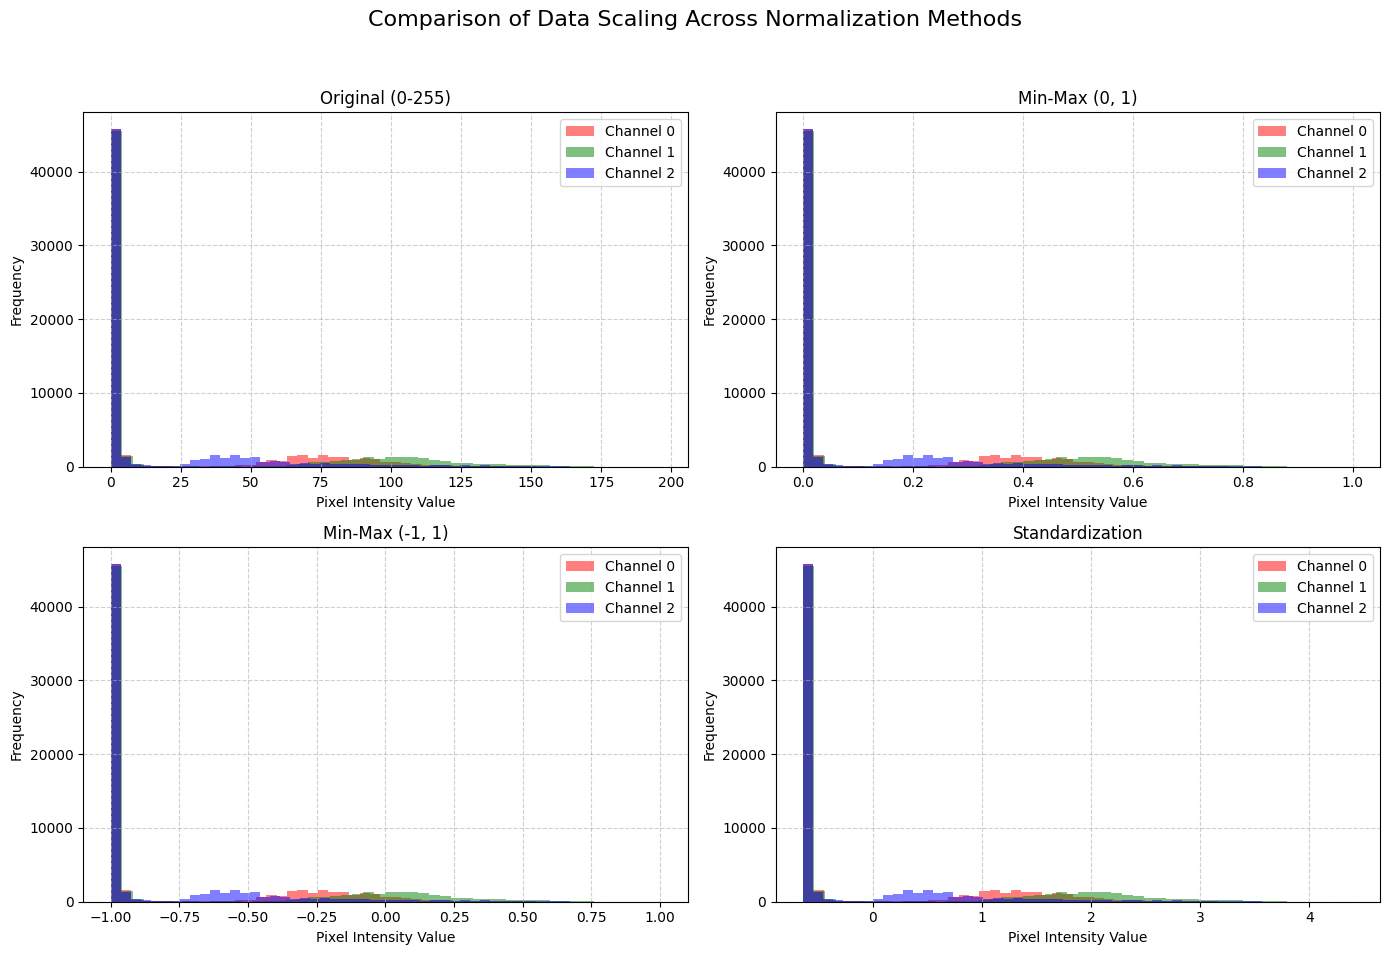

In [ ]:
# SỬA LỖI NAMEERROR VÀ KÍCH HOẠT QUÁ TRÌNH SO SÁNH

# Chọn một hình ảnh mẫu từ dataset để đảm bảo biến `sample_img` tồn tại
sample_path = random.choice(dataset.image_paths)
sample_img = cv2.imread(sample_path)
if sample_img is None:
    raise RuntimeError(f"Không thể đọc tệp: {sample_path}")
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Đảm bảo đối tượng normalizer đã được khởi tạo
# Bước này tạo ra thực thể chứa các phương thức cần thiết
normalizer = ImageNormalizer()

# Truy cập các phương thức thông qua đối tượng 'normalizer'
# Ta sử dụng ký hiệu dấu chấm (object.method) để giải quyết lỗi NameError
# Phương pháp 1: Tỷ lệ hóa về khoảng [0, 1]
img_01 = normalizer.NormMinMax(sample_img, (0, 1))

# Phương pháp 2: Tỷ lệ hóa về khoảng [-1, 1]
img_11 = normalizer.NormMinMax(sample_img, (-1, 1))

# Phương pháp 3: Chuẩn hóa Z-score (Trung bình ≈ 0, Độ lệch chuẩn ≈ 1)
img_std = normalizer.NormStandardization(sample_img)

# THIẾT LẬP TRỰC QUAN HÓA
titles = ['Gốc (0-255)', 'Min-Max (0, 1)', 'Min-Max (-1, 1)', 'Chuẩn hóa (Standardization)']
images = [sample_img, img_01, img_11, img_std]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("So sánh việc thay đổi tỷ lệ dữ liệu giữa các phương pháp chuẩn hóa", fontsize=16)



for i, ax in enumerate(axes.flat):
    for j, color in enumerate(['red', 'green', 'blue']):
        # Làm phẳng các kênh màu để trực quan hóa phân phối pixel
        ax.hist(images[i][..., j].ravel(), bins=50, color=color, alpha=0.5, label=f'Kênh {j}')
    
    ax.set_title(titles[i])
    ax.set_xlabel("Giá trị cường độ Pixel")
    ax.set_ylabel("Tần suất")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4. Edge Detection (Phát hiện biên cạnh - Optional Bonus)
Biên cạnh đóng vai trò quan trọng trong việc xác định ranh giới vùng tổn thương và trích xuất đặc trưng hình thái bệnh.

#### Thuật toán triển khai:
* **Sobel & Prewitt:** Sử dụng đạo hàm bậc nhất để xác định hướng và cường độ biên.
* **Canny (Auto-Threshold):** Sử dụng cơ chế lọc nhiễu Gaussian và khử cực đại. Ngưỡng được xác định tự động dựa trên Median của ảnh: $T_{lower} = 0.7 \times Median$ và $T_{upper} = 1.3 \times Median$.

#### Chỉ số đánh giá định lượng:
* **Edge Coverage (%):** Tỷ lệ điểm ảnh biên trên tổng số điểm ảnh.
* **Mean Intensity:** Cường độ trung bình để đo độ sắc nét của biên.
* **Edge Density:** Dùng để so sánh đặc trưng cấu trúc giữa các lớp bệnh khác nhau. Ví dụ: Các lớp bệnh đốm lá thường có mật độ biên cao hơn các lớp lá khỏe mạnh.

Running Edge Detection Pipeline on all disease classes...


100%|██████████| 38/38 [00:00<00:00, 241.81it/s]


 Dataset-wide average Edge Density statistics:


,Edge_Coverage_%,Mean_Intensity
0,6.728403,255.0


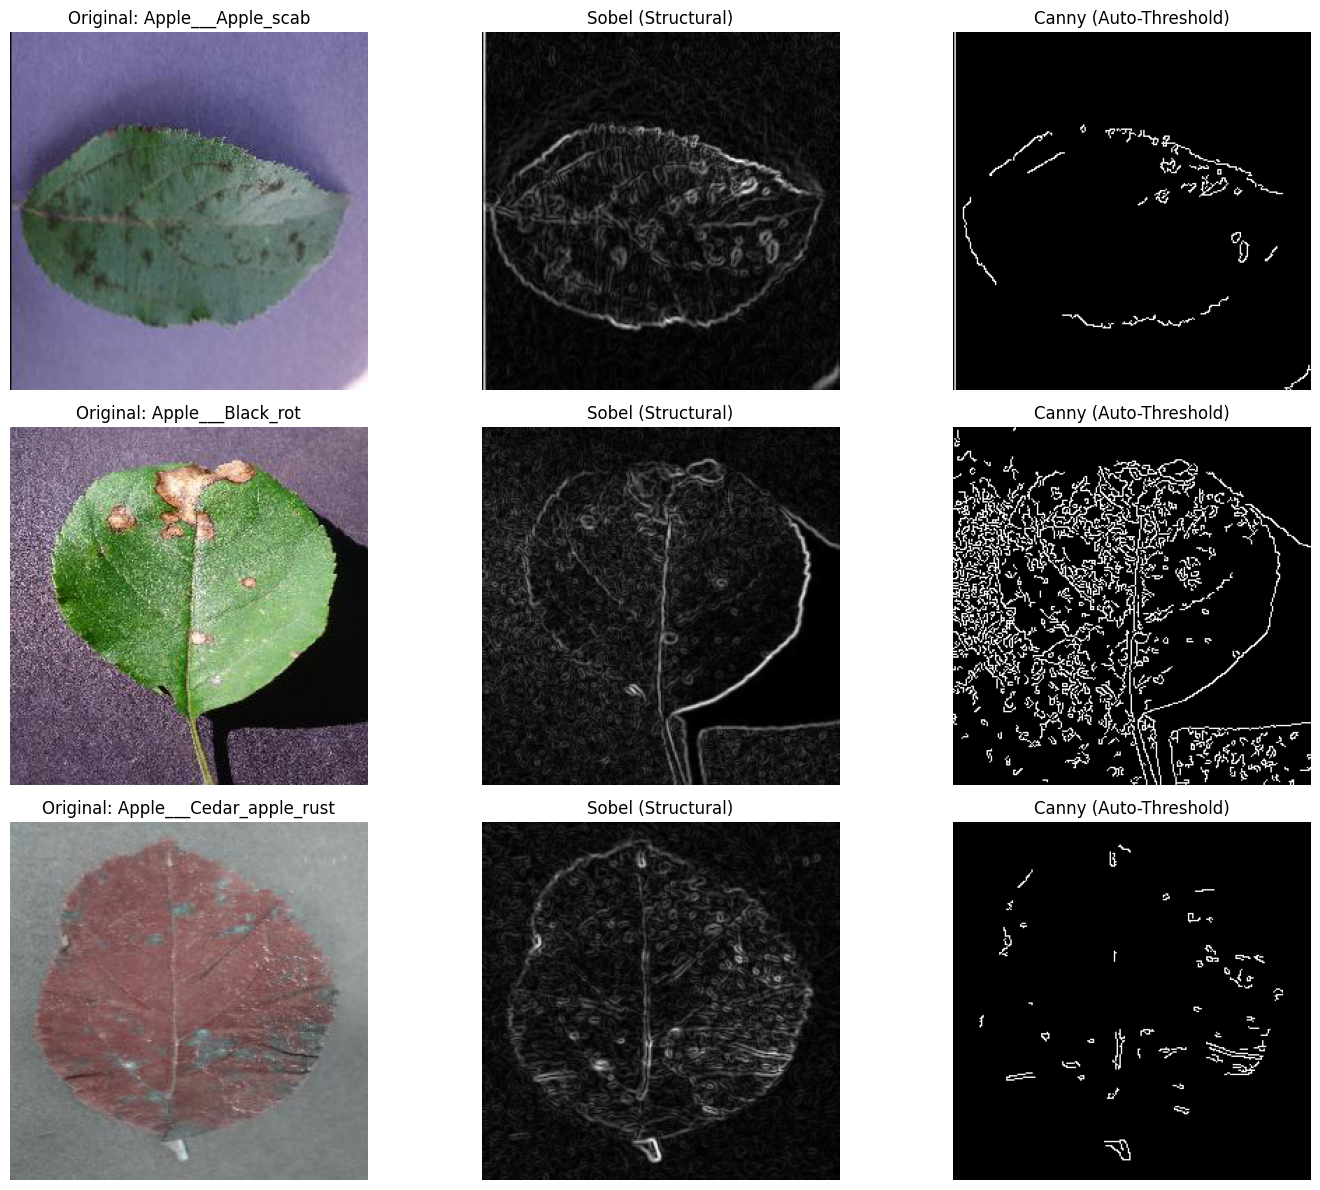

,Class,Edge_Coverage_%,Mean_Intensity
0,Apple___Apple_scab,1.8845,255.0
1,Apple___Black_rot,13.5513,255.0
2,Apple___Cedar_apple_rust,1.5213,255.0
3,Apple___healthy,3.2013,255.0
4,Blueberry___healthy,2.4216,255.0
5,Cherry_(including_sour)___Powdery_mildew,3.2059,255.0
6,Cherry_(including_sour)___healthy,2.1347,255.0
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,6.7810,255.0
8,Corn_(maize)___Common_rust_,3.2104,255.0
9,Corn_(maize)___Northern_Leaf_Blight,10.0433,255.0


In [ ]:
# PHÂN TÍCH PHÁT HIỆN CẠNH (EDGE DETECTION ANALYSIS)
class EdgeAnalyzer:
    def __init__(self, dataset, label_to_paths):
        """
        Khởi tạo bộ phân tích với dataset và ánh xạ nhãn.
        """
        self.dataset = dataset
        self.label_to_paths = label_to_paths
        self.edge_results = []
        self.visual_comparison = []

    def GetAutoCanny(self, img_uint8):
        """
        Phát hiện cạnh Canny tự động dựa trên giá trị trung vị (median) của cường độ pixel.
        """
        v = np.median(img_uint8)
        
        # Áp dụng logic: thiết lập ngưỡng xung quanh giá trị trung vị (70% và 130%)
        low = int(max(0, 0.7 * v))
        high = int(min(255, 1.3 * v))
        
        return cv2.Canny(img_uint8, low, high)

    def CalculateEdgeMetrics(self, edge_map):
        """
        Tính toán các chỉ số định lượng: Độ phủ cạnh (Edge Coverage) và Cường độ trung bình (Mean Intensity).
        """
        # Độ phủ: Tỷ lệ phần trăm các pixel được xác định là cạnh (khác không)
        coverage = np.count_nonzero(edge_map) / edge_map.size * 100
        
        # Cường độ trung bình: Độ sáng trung bình của các cạnh được phát hiện
        intensity = edge_map[edge_map > 0].mean() if np.any(edge_map) else 0
        
        return round(coverage, 4), round(intensity, 4)

    def RunPipeline(self):
        """
        Thực thi quy trình phát hiện cạnh trên tất cả các lớp bệnh lý.
        """
        print("Đang chạy Quy trình phát hiện cạnh trên tất cả các lớp bệnh lý...")
        
        for i, (label, paths) in enumerate(tqdm(self.label_to_paths.items())):
            # Chọn ngẫu nhiên một hình ảnh từ mỗi lớp
            img_path = random.choice(paths)
            img_raw = cv2.imread(img_path)
            if img_raw is None: 
                continue
            
            img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
            
            # Tiền xử lý: Chuyển sang ảnh xám và giảm nhiễu (Gaussian Blur)
            img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
            img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
            
            # Phương pháp 1: Toán tử Sobel (Dựa trên gradient)
            sx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=3)
            sy = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=3)
            edge_sobel = np.hypot(sx, sy)
            
            # Phương pháp 2: Toán tử Canny (Tự động tính ngưỡng dựa trên trung vị)
            edge_canny = self.GetAutoCanny(img_blur)
            
            # Trích xuất các chỉ số thống kê từ kết quả Canny
            cov, intens = self.CalculateEdgeMetrics(edge_canny)
            
            self.edge_results.append({
                "Class": self.dataset.idx_to_class[label],
                "Edge_Coverage_%": cov,
                "Mean_Intensity": intens
            })
            
            # Lưu trữ 3 mẫu đầu tiên để so sánh trực quan song song
            if i < 3:
                self.visual_comparison.append({
                    "name": self.dataset.idx_to_class[label],
                    "rgb": img_rgb, 
                    "sobel": edge_sobel, 
                    "canny": edge_canny
                })

    def ExportAndDisplay(self, filename='edge_detection_report.csv'):
        """
        Tạo báo cáo thống kê và vẽ biểu đồ so sánh trực quan.
        """
        # Tạo và lưu báo cáo
        df = pd.DataFrame(self.edge_results)
        df.to_csv(filename, index=False)
        
        print("\n Thống kê trung bình mật độ cạnh trên toàn bộ Dataset:")
        display(df[["Edge_Coverage_%", "Mean_Intensity"]].mean().to_frame().T)
        
        # Minh họa trực quan: RGB | Sobel | Canny
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        for i, sample in enumerate(self.visual_comparison):
            axes[i, 0].imshow(sample['rgb'])
            axes[i, 0].set_title(f"Gốc: {sample['name']}")
            
            axes[i, 1].imshow(sample['sobel'], cmap='gray')
            axes[i, 1].set_title("Sobel (Cấu trúc)")
            
            axes[i, 2].imshow(sample['canny'], cmap='gray')
            axes[i, 2].set_title("Canny (Ngưỡng tự động)")
            
            for ax in axes[i]: 
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return df
    
# KÍCH HOẠT PHÂN TÍCH PHÁT HIỆN CẠNH

# Khởi tạo EdgeAnalyzer
# Yêu cầu đối tượng dataset và ánh xạ nhãn-đường dẫn đã tạo trước đó
edge_analyzer = EdgeAnalyzer(dataset, evaluator.LabelToPaths)

# Chạy quy trình xử lý
# Thực hiện làm mờ Gaussian, phân tích cấu trúc Sobel và phát hiện Auto-Canny
edge_analyzer.RunPipeline()

# Xuất dữ liệu và trực quan hóa kết quả
# Tạo báo cáo CSV và hiển thị so sánh song song các phương pháp phát hiện cạnh
edge_analyzer.ExportAndDisplay(filename='plant_disease_edges.csv')